# TP1: Conversion of Sampling Frequency and STFT

*By Daniel Jorge Deutsch, Kevin Kuhl and Santiago Velandia (25/09/2020)*

In [18]:
import os
import struct
import sys
import wave
from copy import deepcopy
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile

In [19]:
class Signal:

    def __init__(self, name, signal=None, freq=None, file=None):

        if not (file or not signal is None):
            raise Exception("You must at least pass a signal or a .wav file")
        if file and not signal is None:
            raise Exception("You can only pass a signal or a .wav file (not both)")

        self.name = name 

        if not signal is None:
            self.signal = np.asarray(signal)
            if not freq:
                raise Exception("Since you provided the signal you should pass its freq")
            self.freq = int(freq)
        if file:
            self.file = file
            self.freq, self.signal = wavfile.read(self.file)
            self.freq = int(self.freq)
            self.signal = np.asarray(self.signal)
            
    
    #------------------------------#
    #--- OPERATIONS ---------------#
    #------------------------------#

    def convolve(self, name, signal):
        if not (self.freq or signal.freq):
            raise Exception("the sample freq (sample/sec) must be provided")
        freq = signal.freq if signal.freq else self.freq
        return self.__class__(name, signal=np.convolve(self.signal, signal.signal), freq=freq)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def remove_samples(self, name, M):
        if not isinstance(M, int):
            raise Exception("M must be an integer")
        res = self.signal[::M]
        return self.__class__(name=name, signal=res, freq=self.freq/M)


    def insert_zeros(self, name, L):
        if not isinstance(L, int):
            raise Exception("L must be an integer")
        res = np.insert(self.signal, range(1, len(self.signal)+1)[::L-1], 0)
        return self.__class__(name=name, signal=res, freq=self.freq*L)


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#

    def time_plot(self, freq=None, figsize=(30, 4), save=False):
        if not (self.freq or freq):
            raise Exception("the sample freq (sample/sec) must be provided")
        freq = freq if freq else self.freq
        xaxis = np.arange(len(self.signal))/freq
        plt.figure(figsize=figsize)
        plt.fill_between(xaxis, self.signal)
        plt.xlim(xaxis[0], xaxis[-1])
        plt.title(f"Time plot of {self.name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()

    
    def filter_response_plot(self, figsize=(15, 4), save=False):
        xaxis, yaxis = sig.freqz(self.signal)   
        xaxis = xaxis/(2*np.pi)                 # Frequency of the signal in (rad/sample)/2π
        yaxis = 10*np.log10(abs(yaxis))         # Magnitude of the signal
        plt.figure(figsize=figsize)
        plt.title(f"Frequency response of {self.name}")
        plt.xlabel("Frequency ((rad/sample)/2π)")
        plt.ylabel(f"Magnitude of {self.name} (dB)")
        plt.plot(xaxis, yaxis)
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freq_res.png", dpi=300, bbox_inches="tight")
        plt.show()


    def fft_plot(self, figsize=(15, 4), save=False, window=False):
        fft_size = 4096
        
        A = np.fft.fft(self.signal,fft_size)

        mag = np.abs(np.fft.fftshift(A))

        freq = np.linspace(-0.5, 0.5, len(A))

        with np.errstate(divide='ignore', invalid='ignore'):
            response = 20 * np.log10(mag)

        response = np.clip(response, -150, 150)

        plt.figure(figsize=figsize)
        
        plt.plot(freq, response)

        plt.title("Frequency response of {}".format(self.name))

        plt.ylabel("Magnitude [dB]")

        plt.xlabel("Normalized frequency [cycles per sample]")
        if window:
            plt.title("Frequency response of {} (main lobe width: {})".format(self.name,4/len(w.signal)))
            plt.axvline(x=-2/len(w.signal), color="red")
            plt.axvline(x=2/len(w.signal), color="red")
        
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_fft.png", dpi=300, bbox_inches="tight")
        
        plt.show()


    
    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#
    
    def listen(self, freq=None, chunk=1024):
        
        # Saves the .wav
        if not (self.freq or freq):
            raise Exception("the sample freq (sample/sec) must be provided")
        freq = freq if freq else self.freq
        wavfile.write(f"./outputs/sounds/{self.name}.wav", freq, np.asarray(self.signal, dtype=np.int16))

        # Uses pyaudio to play the signal
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            freq = audio.getframefreq(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [29]:
class Filter:

    def __init__(self, name, signal):
        self.name = name
        self.signal = signal

    
    def apply(self, name, signal):
        convolved = np.convolve(self.signal, signal.signal)
        return Signal(name, signal=convolved, freq=signal.freq)

    
    def time_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        xaxis = np.linspace(-0.5, 0.5, len(self.signal)) ################### ISSO TA ERRADO
        plt.figure(figsize=figsize)
        plt.title(f"Time plot of {self.name}")
        plt.plot(xaxis, self.signal)
        plt.xlim(xaxis[0], xaxis[-1])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(x=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()

    
    def fft_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        fft_size = 4096
        
        A = np.fft.fft(self.signal,fft_size)

        mag = np.abs(np.fft.fftshift(A))

        freq = np.linspace(-0.5, 0.5, len(A))

        with np.errstate(divide='ignore', invalid='ignore'):
            response = 20 * np.log10(mag)

        response = np.clip(response, -150, 150)

        plt.figure(figsize=figsize)
        
        plt.plot(freq, response)

        plt.title("Frequency response of {}".format(self.name))

        plt.ylabel("Magnitude [dB]")

        plt.xlabel("Normalized frequency [cycles per sample]")
        
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()   

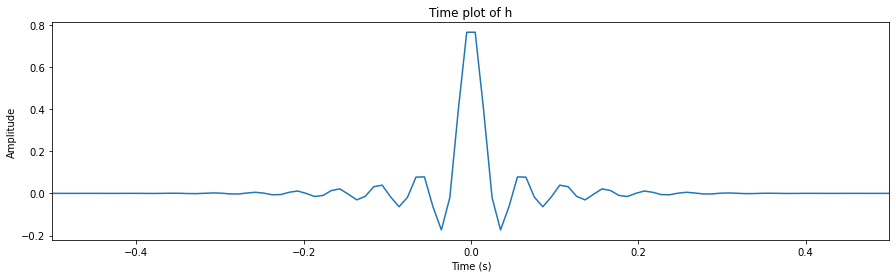

In [30]:
# Obtains the input signal x from its file
x = Signal(name="x", file="./inputs/caravan_48khz.wav")

# Defines the over and under sampling constants
L = 2
M = 3

# Obtains the over sampled signal w using L=2 (Fw=48*2=96kHz)
w = x.insert_zeros("w", L)

# Defines the Remez filter params
numtaps = 100                       # An even number (can't be too big)
trans_width = 1/13                  # ?
cutoff = min( 1/(2*L), 1/(2*M) )    # Cutoff frequency (should be 1/(2*M) = 1/6)

# Obtains the Remez filter
h = Filter(name="h", signal=sig.remez(numtaps, [0, cutoff, cutoff+trans_width, 1/2], [L, 0]))
h.time_plot()
# Calculates the convolution v=w*h
v = h.apply(name="v", signal=w)

# Undersample the convolution result to obtain the output of the system using M=3 (Fy=96/3=32kHz)
y = v.remove_samples("y", M)

# Polyphase

In [22]:
h0 = Signal("h0", h.signal[::2], h.freq/2)
h1 = Signal("h1", h.signal[1::2], h.freq/2)

w0 = x.convolve("w0", h0)
w1 = x.convolve("w1", h1)

v0 = w0.insert_zeros("v0", 2)
v1 = w1.insert_zeros("v1", 2)

v0.signal = np.append([0],v0.signal[:-1])

v = Signal("v", v0.signal+v1.signal, v0.freq)


#------------------------------#
#--- LISTEN -------------------#
#------------------------------#

u0 = Signal("u0", v.signal, v.freq)
u1 = Signal("u1", np.append([0],v.signal[:-1]), v.freq)
u2 = Signal("u2", np.append([0, 0],v.signal[:-2]), v.freq)

a0 = u0.remove_samples("a0", M)
a1 = u1.remove_samples("a1", M)
a2 = u2.remove_samples("a2", M)

h0 = Signal("h0", h.signal[:-1:3], h.freq/2)
h1 = Signal("h1", h.signal[1::3], h.freq/2)
h2 = Signal("h2", h.signal[2::3], h.freq/2)

y0 = a0.convolve("y0", h0)
y1 = a1.convolve("y1", h1)
y2 = a2.convolve("y2", h2)

y = Signal("y", y0.signal+y1.signal+y2.signal, a0.freq)
h.filter_response_plot()
y.fft_plot()

AttributeError: &#39;Filter&#39; object has no attribute &#39;freq&#39;

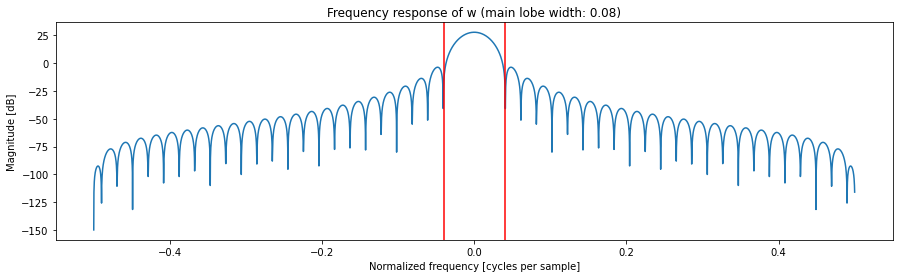

In [13]:
N = x.signal.shape[0] # % longueur du signal
Nw = 50
w = np.hanning(Nw)  # définition de la fenetre d'analyse
ws = w.copy   # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1   # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

w = Signal("w", w, freq=32000)
w.fft_plot(window=True)